In [1]:
%load_ext autoreload
%autoreload 2

import json
import logging
from math import pi, log, log2, sqrt
from pathlib import Path
import scipy.stats
import torch
from torch import tensor, Tensor

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import weight_formats.analysis as A
import weight_formats.quantisation as Q
import data_utils as D
import plot_utils

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plot_utils.OVERLEAF = None
plot_utils.configure()
Path("blog").mkdir(exist_ok=True)

2025-07-11:14:05:45,236 INFO     [rouge_scorer.py:83] Using default tokenizer.
2025-07-11:14:05:45,599 INFO     [_client.py:1025] HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra


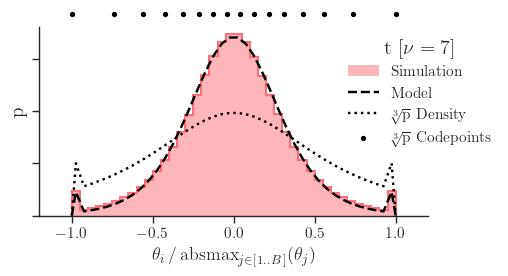

In [3]:
block_size = 64
df = 7
X = A.StudentT(df=df).sample(2**22, seed=1, device=DEVICE) # 2**24
bins = torch.linspace(-1, 1, 41)

_, ax = plt.subplots(figsize=(5, 3))

mids = (bins[:-1] + bins[1:]) / 2
scale = ((2 * log(block_size / pi)) ** ((3-df)/(2*df))
            * block_size ** (-1/df)
            * sqrt((df-2)/df))
c0, c1 = scipy.stats.t.cdf([-1, 1], df, scale=scale)
model = tensor(scipy.stats.t.pdf(mids, df, scale=scale) / (c1 - c0) * 2 / len(mids) * (block_size - 1) / block_size)
model[0] += 0.5 / block_size
model[-1] += 0.5 / block_size

Xn = Q.block_normalise(X, (block_size,), "absmax", (-1, 1), Q.FP32)[0].cpu()
W = torch.full_like(X, 1/X.nelement()).cpu()
color = "#ff6f79"
ax.hist(Xn, bins=bins, weights=W, color=color, histtype="bar", linewidth=0, alpha=.5, label="Simulation")
ax.hist(Xn, bins=bins, weights=W, color=color, histtype="step", linewidth=1.5)
ax.plot(torch.cat([tensor([-1]), mids, tensor([1])]), torch.cat([tensor([0]), model, tensor([0])]),
        color="k", lw=1.75, ls="--", zorder=10,
        label="Model")
cube_root_model = model ** (1/3)
cube_root_model /= cube_root_model.sum()
ax.plot(torch.cat([tensor([-1]), mids, tensor([1])]), torch.cat([tensor([0]), cube_root_model, tensor([0])]),
        color="k", lw=1.75, ls=":", zorder=10,
        label=f"{plot_utils.CRD_LABEL} Density")

centroids = Q.crd_block_t(4, block_size=block_size, df=df)
ax.scatter(centroids.values, [0.077 for _ in centroids.values], color="k", label=f"{plot_utils.CRD_LABEL} Codepoints")

ax.set_xlim((-1.2, 1.2))
ax.set_xlabel(f"$\\theta_i \\,/\\, \\mathrm{{absmax}}_{{j\\in[1..B\\,]}}(\\theta_j)$", fontsize=13)

ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.02))
ax.tick_params(labelleft=False)
ax.set_ylabel(r"$\mathrm{p}$")
ax.set_ylim((0, 0.079))
ax.spines['left'].set_bounds(0, 0.072)

plot_utils.set_figure_legend(ax.figure, *ax.get_legend_handles_labels(), title=f"t [$\\nu={df}$]", bbox_to_anchor=(0.75, 0.65))
plot_utils.tidy(ax.figure)
ax.figure.set_alpha(0)
Path("poster").mkdir(exist_ok=True)
ax.figure.savefig("poster/box_figure.png", bbox_inches="tight", transparent=True, dpi=600)